## Query Script:

At first we can ask ourselves: for any given unique ticker in one day found on yahoo, did we find the same ticker in reddit posts? That is, we want to dvelve into the number of unique matches found per each day in the datasets. 

Now comes a problem though: we can imagine the number of matches to be limited from the dimension of the reddit unique ticker dataset, since it will probably be much smaller than the number of unique tickers found on yahoo.

So, clearly considering the number of matches alone tells us nothing, but also considering the % number of matches does not tell the complete picture since we would have to either divide the number of matches by unique reddit tickers or unique yahoo tickers or the sum of both, but all figures would be skewed by the disproportionality in the two lists. As such the best way is to consider a weighted average of the % matches on yahoo unique tickers and reddit unique ticker, weighted on the inverse of the list dimension. 

Let M be the number of matches, Y the dimension of the unique ticker list from Yahoo and R the dimension of the unique ticker list from Reddit. Then:

$ M_{y} = \frac{M}{Y} $ , $ M_{r} = \frac{M}{R} $, 

And we can measure the % number of matches found using a weighted average as such (let MFW be the weighted frequency of matches):

$ MFW = (M_{y}\frac{1}{Y}+M_{r}\frac{1}{R})(\frac{1}{Y}+\frac{1}{R})^{-1} $ which simplifies further to a clean:  $ MFW = M \frac{(R^2+Y^2)}{(R+Y)RY} $

In [1]:
# remember to run export PYENCHANT_LIBRARY_PATH=/opt/homebrew/lib/libenchant-2.dylib before launching this notebook

from yahoo_fin.stock_info import get_day_gainers
from yahoo_fin.stock_info import get_day_losers
from yahoo_fin.stock_info import get_day_most_active
from yahoo_fin.stock_info import get_live_price
from yahoo_fin.stock_info import get_quote_table
import requests
import praw
from textblob import TextBlob
import re
import json
import nltk 
from nltk.corpus import words
import enchant
import pandas as pd
import numpy as np
import warnings
import time
from datetime import datetime, timedelta
import pymongo
from pymongo import MongoClient
from pymongo.server_api import ServerApi
import yfinance as yf
from pandas_datareader import data as pdr
import random
import itertools
import pytz
import matplotlib.pyplot as plt

We then connect to our database

In [2]:
url = #insert your MongoDb connections details here
client = MongoClient(url, server_api=ServerApi('1'))
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [4]:
db = #insert your MongoDb Dabatase name here
collection1 = db['RedditPosts_enriched']
collection2 = db['YahooData_enriched']

Now we just have to compute our query for each day and plot it!

In [36]:
datelist, corrlist, match=[datetime(2024, 1, 16+i, 0, 0, 0) for i in range(11) if i!=4 and i!=5 and i!=8], [], []
for date in datelist: 
    unique_symbols_yahoo = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    unique_symbols_reddit = collection1.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    matches=[]
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo:
            matches.append(element)
    R, Y, M=len(unique_symbols_reddit), len(unique_symbols_yahoo), len(matches)
    match.append(M)
    corrlist.append(M*(pow(R, 2)+pow(Y, 2))/((R+Y)*R*Y))

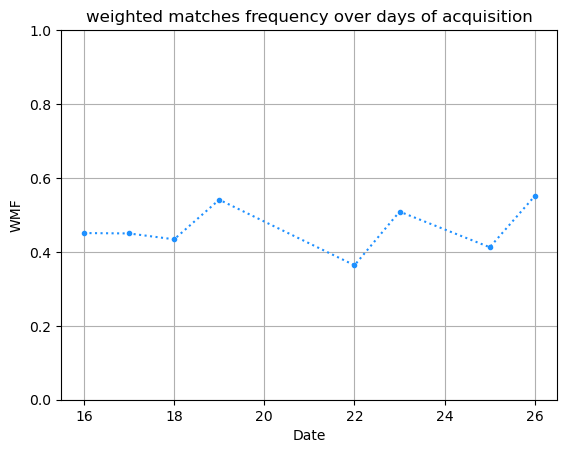

In [37]:
date_objects = [date.day for date in datelist]
# Plotting
plt.plot(date_objects, corrlist, marker='.', linestyle=':', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('WMF')
plt.title('weighted matches frequency over days of acquisition')
plt.ylim(0, 1)
plt.grid(True)
plt.savefig('MFW.png', dpi=300)
plt.show()

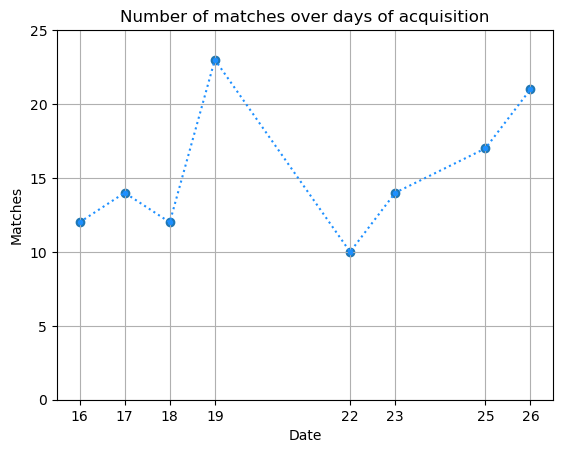

In [38]:
date_objects = [date.day for date in datelist]
# Plotting
plt.scatter(date_objects, match)
plt.plot(date_objects, match, marker='.', linestyle=':', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Matches')
plt.title('Number of matches over days of acquisition')
plt.xticks(date_objects)
plt.ylim(0, 25)
plt.grid(True)
plt.savefig('matches.png', dpi=300)
plt.show()

All of this demonstrates that in general we have quite the number of posts on reddit that find a match in symbol with ones on yahoo. But we have to keep in mind that in general reddit unique tickers are much more than yahoo unique tickers: 

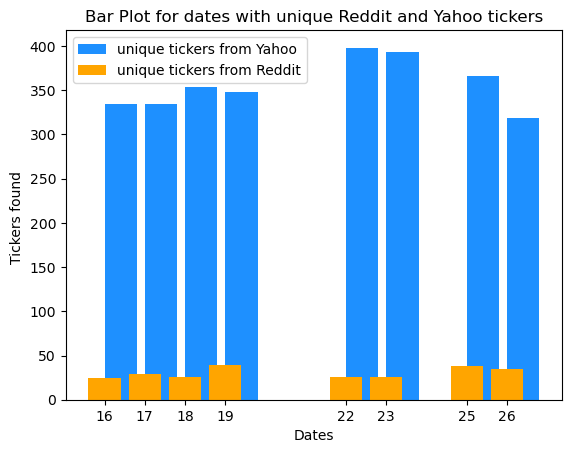

In [39]:
datelist, unique_yahoo, unique_reddit=[datetime(2024, 1, 16+i, 0, 0, 0) for i in range(11) if i!=4 and i!=5 and i!=8], [], []
for date in datelist: 
    unique_symbols_yahoo = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    unique_symbols_reddit = collection1.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    unique_yahoo.append(len(unique_symbols_yahoo))
    unique_reddit.append(len(unique_symbols_reddit))
date_objects = [date.day for date in datelist]
unique_yahoo=[unique_yahoo[i]-unique_reddit[i] for i in range(len(unique_yahoo))]
plt.bar(date_objects, unique_yahoo, label='unique tickers from Yahoo', color='dodgerblue', align='edge')
plt.bar(date_objects, unique_reddit, label='unique tickers from Reddit', color='orange')

plt.xlabel('Dates')
plt.ylabel('Tickers found ')
plt.title('Bar Plot for dates with unique Reddit and Yahoo tickers')
plt.xticks(date_objects)
plt.legend()
plt.savefig('Tickersbyday.png', dpi=300)
plt.show()

So we can say that there indeed is a correlation between what people talk about on reddit and what is instead traded and has high volume during that specific day, but this correlation seems to be mostly driven by the fact that reddit folks post a lot about popular stocks, which are already in the active market section, and not viceversa: it is harder indeed to show that markets are or are not moved by reddit posts. 

Now, since we see that we have quite the number of matches basically for every day, we can take ask ourselves: are redditors posting more attracted to winning or losing stocks? Is the discussion more focused on stocks going down, or on stocks going up? That is, per each day we can compute the number of matches that are also losers, gainers, and none of the other two categories. Then we can plot per each day the numeber of matches but highlighting this ditribution:

In [40]:
datelist=[datetime(2024, 1, 16+i, 0, 0, 0) for i in range(11) if i!=4 and i!=5 and i!=8]

In [41]:
match, loser, gainer=[], [], []
for date in datelist: 
    unique_symbols_yahoo = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    unique_symbols_reddit = collection1.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    matches=[]
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo:
            matches.append(element)
    gainer_matches=[]
    unique_symbols_yahoo_gainers = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}, "is_gainer": 1})
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo_gainers:
            gainer_matches.append(element)
    loser_matches=[]
    unique_symbols_yahoo_losers = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}, "is_loser": 1})
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo_losers:
            loser_matches.append(element)
    match.append(len(matches))
    loser.append(len(loser_matches))
    gainer.append(len(gainer_matches))

In [42]:
match=[match[i]-loser[i]-gainer[i] for i in range(len(match))]

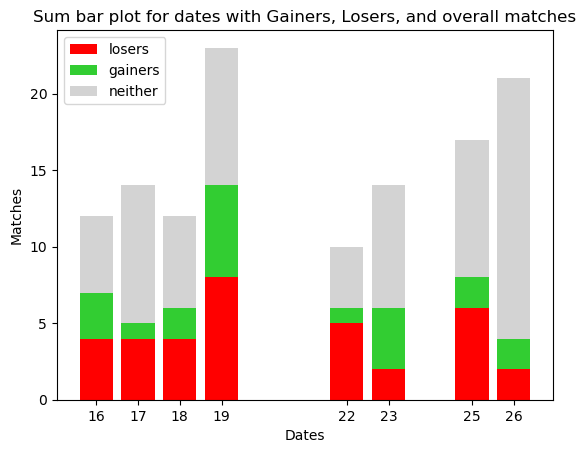

In [50]:
date_objects = [date.day for date in datelist]
plt.bar(date_objects, loser, label='losers', color='red')
plt.bar(date_objects, gainer, bottom=loser, label='gainers', color='limegreen')
plt.bar(date_objects, match, bottom=np.array(loser) + np.array(gainer), label='neither', color='lightgrey')

plt.xlabel('Dates')
plt.ylabel('Matches')
plt.title('Sum bar plot for dates with Gainers, Losers, and overall matches')
plt.legend()
plt.xticks(date_objects)
plt.savefig('gainerslosers.png', dpi=300)
plt.show()


So in general we can see that the discussion focuses either on neither losing nor winning stocks or losing stocks overall, at least for each day.

At last, we can check between tickers recorded over all days if they are large or with average market capitalization; we can not check on if there are matches with small capitalization since yahoo finance excludes small cap stocks from gainers, losers and active. Thorugh this we can see if there is a focus on some stock type:

In [51]:
large_cap_threshold=10000000000
mid_cap_threshold=200000000
largecap, midcap= [], []
for date in datelist: 
    unique_symbols_reddit = collection1.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)}})
    unique_symbols_yahoo_largecap = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)},
                                                                    "Market Cap": {"$gte": large_cap_threshold}})
    largecap_matches=[]
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo_largecap:
            largecap_matches.append(element)
    midcap_matches=[]
    unique_symbols_yahoo_midcap = collection2.distinct("Symbol", {"acquisition_time": {"$gte": date, "$lt": date + timedelta(days=1)},
                                                                  "Market Cap": {"$gte": mid_cap_threshold, "$lt": large_cap_threshold}})
    for element in unique_symbols_reddit:
        if element in unique_symbols_yahoo_midcap:
            midcap_matches.append(element)
    largecap.append(len(largecap_matches))
    midcap.append(len(midcap_matches))
midcap_tot=sum(midcap)
largecap_tot=sum(largecap)

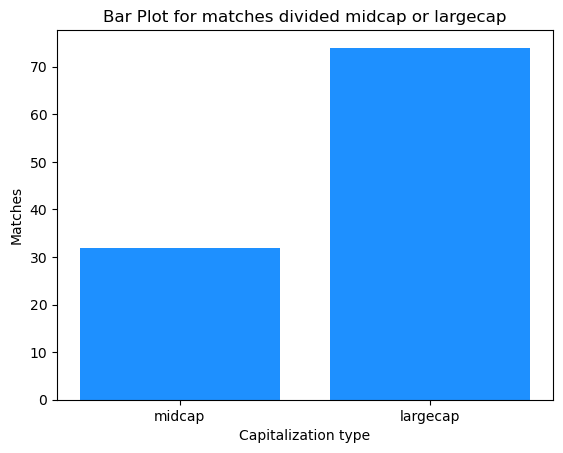

In [55]:
xvalues = ['midcap', 'largecap']
plt.bar(xvalues, [midcap_tot, largecap_tot], label='matches', color='dodgerblue')

plt.xlabel('Capitalization type')
plt.ylabel('Matches')
plt.title('Bar Plot for matches divided midcap or largecap')
plt.xticks(xvalues)
plt.savefig('Cap.png', dpi=300)
plt.show()

So we can clearly see the talk is large-cap oriented.

One last thing: we can notice that in this last plot the number of matches (sum of 72 and 30) is 102 and not 123 (sum of all matches throughout the days). One could ask itself why is this, but we can recall from our cleaning_integration_script that the yahoo_enriched dataset had 21 missing values in market cap fields! Which is exactly the number of matches we are missing here. So we have indeed lost some information about the distribution of market capitalization, but in any case we can notice that the number of largecap is more then midcap+missing values or smallcap+missing values so our conclusion remains the same no matter what.